# Proyecto 2 - Limpieza de imágenes

- Sebastian Aristondo 20880  
- Diego Franco 20240  
- Manuel Archila 161250  
- Juan Diego Avila 20090  
- Daniel Gonzalez Carrillo 20293  

In [2]:
import pandas as pd
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import ndimage
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import cv2
from PIL import Image
import zipfile
import io

In [3]:
data = pd.read_csv('meta_train_with_vertebrae.csv', encoding='utf-8')

In [4]:
data.head()

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,SliceRatio,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,1,512,512,0.625,-52.308,-27.712,7.282,0.003731,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10001,2,512,512,0.625,-52.308,-27.712,6.657,0.007463,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10001,3,512,512,0.625,-52.308,-27.712,6.032,0.011194,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.10001,4,512,512,0.625,-52.308,-27.712,5.407,0.014925,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.10001,5,512,512,0.625,-52.308,-27.712,4.782,0.018657,0,0,0,0,0,0,0


In [5]:
def extract_number(filename):
    # Extraer el número de la cadena (por ejemplo, "10" de "10.dcm")
    return int(filename.split('.')[0])

In [6]:
def read_images(path):
    # Obtener la lista de nombres de archivos de imágenes
    image_files = os.listdir(path)
    image_files.sort(key=extract_number)  # Asegura un orden adecuado
    
    # Inicializar una lista para almacenar los volúmenes 3D
    volumes = []

    # Leer y apilar las imágenes en un volumen 3D
    for image_file in image_files:
        image_path = os.path.join(path, image_file)
        dicom_data = pydicom.dcmread(image_path)
        image = apply_voi_lut(dicom_data.pixel_array, dicom_data)
        volumes.append(image)

    # Convertir la lista de volúmenes a un arreglo NumPy 3D
    volumes_array = np.stack(volumes, axis=-1)

    # Normalizar los valores de píxeles en el rango [0, 1]
    # Esto puede variar dependiendo de la información específica de las imágenes DICOM
    volumes_array = (volumes_array - np.min(volumes_array)) / (np.max(volumes_array) - np.min(volumes_array))
    return volumes_array

In [7]:
# image_path = "train_images/1.2.826.0.1.3680043.27/30.dcm"
# dicom_data = pydicom.dcmread(image_path)
# # Obtener los píxeles de la imagen
# image_pixels = dicom_data.pixel_array

# # Mostrar la imagen
# plt.imshow(image_pixels, cmap=plt.cm.bone)
# plt.axis('off')  # Ocultar ejes
# plt.show()

In [8]:
def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

In [9]:
def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 300
    desired_width = 256
    desired_height = 256
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [10]:
def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_images(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [11]:
# # CHUNK TEMPORAL
# data_dir = 'train_images/1.2.826.0.1.3680043.27/'
# volume = process_scan(data_dir)
# output_file = "volumen3D.npy"
# np.save(output_file, volume)

In [13]:
root = "train_images"
save_dir = "volumes"
patients = os.listdir(root)
count = 0
for patient in patients:
    patient_dir = os.path.join(root, patient)
    volumes = process_scan(patient_dir)
    output_file = "volumes/" + patient + ".npy"
    np.save(output_file, volumes)
    #if count >= 10:
    #    break
    #count += 1

C:\Users\Daniel\AppData\Local\Temp\ipykernel_29716\1781923139.py:21: RuntimeWarning: invalid value encountered in divide
  volumes_array = (volumes_array - np.min(volumes_array)) / (np.max(volumes_array) - np.min(volumes_array))


KeyboardInterrupt: 

In [15]:
# load_v = np.load('volumes/1.2.826.0.1.3680043.10136.npy')

In [16]:
# def update_slice(num):
#     plt.clf()  # Limpiar la figura antes de agregar un nuevo cuadro
#     plt.imshow(load_v[:, :, num], cmap='gray')  # Mostrar una rebanada en la posición 'num'
#     plt.title('CT Scan Slice {}'.format(num))
#     plt.axis('off')

# # Crear la figura
# fig = plt.figure()
# # Crear la animación llamando a la función 'update_slice' para cada cuadro
# ani = animation.FuncAnimation(fig, update_slice, frames=load_v.shape[2], interval=100)

# # Ruta y nombre del archivo GIF
# gif_path = "ct_scan_animation.gif"

# # Guardar la animación como un archivo GIF
# ani.save(gif_path, writer='imagemagick')

# print("Animación guardada como", gif_path)

In [5]:
path = 'imagenes_train'
image_files = os.listdir(path)
image_files = [x.split('.zip')[0] for x in image_files]

df = pd.read_csv('train.csv', encoding='utf-8')

condicion = df["StudyInstanceUID"].isin(image_files)

df_filta = df[condicion]

df_filta.to_csv('train_filtrado_images.csv', index=False)

In [5]:
# import SimpleITK as sitk

# path = "train_images/1.2.826.0.1.3680043.14/1.dcm"
# series_reader = sitk.ImageSeriesReader()
# series_reader.SetFileNames([path])
# series_reader.MetaDataDictionaryArrayUpdateOn()
# series_reader.LoadPrivateTagsOn()



In [22]:
# import os
# import pydicom
# import nibabel as nib
# import shutil

# def convert_dcm_to_nii(input_folder, output_folder):
#     # Recorre las carpetas en la carpeta 'train_images'
#     for root, dirs, files in os.walk(input_folder):
#         for dir_name in dirs:
#             input_subdir = os.path.join(root, dir_name)
#             output_subdir = os.path.join(output_folder, dir_name)

#             # Crea la subcarpeta en 'nifti' con el mismo nombre
#             os.makedirs(output_subdir, exist_ok=True)
#             # print(output_subdir)
#             # Itera sobre los archivos .dcm en la carpeta actual
#             for filename in os.listdir(input_subdir):
#                 if filename.endswith('.dcm'):
#                     path = os.path.join(input_subdir, filename)
#                     series_reader = sitk.ImageSeriesReader()
#                     series_reader.SetFileNames([path])
#                     series_reader.MetaDataDictionaryArrayUpdateOn()
#                     series_reader.LoadPrivateTagsOn()
#                     output_path = os.path.join(output_subdir, filename.replace('.dcm', '.nii.gz'))
#                     try:
#                         ct_scan = series_reader.Execute()
#                         sitk.WriteImage(ct_scan, output_path)
#                     except RuntimeError:
#                         print("DicomImageReadError")


# input_folder = 'train_images/'
# output_folder = 'nifti/'
# convert_dcm_to_nii(input_folder, output_folder)


In [63]:
import os
import pydicom
from PIL import Image

# Ruta de la carpeta con archivos DICOM
carpeta_dicom = "train_images/1.2.826.0.1.3680043.14"

# Ruta de la carpeta donde se guardarán las imágenes en formato JPG
carpeta_jpg = "imagenes"

# Obtener lista de archivos DICOM en la carpeta
archivos_dicom = [f for f in os.listdir(carpeta_dicom) if f.endswith('.dcm')]

# Crear la carpeta para guardar las imágenes JPG si no existe
if not os.path.exists(carpeta_jpg):
    os.makedirs(carpeta_jpg)

# Iterar sobre los archivos DICOM y convertirlos a JPG
for archivo_dicom in archivos_dicom:
    ruta_archivo_dicom = os.path.join(carpeta_dicom, archivo_dicom)
    imagen_dicom = pydicom.dcmread(ruta_archivo_dicom)

    gray_image = imagen_dicom.pixel_array

    # Normalizar la imagen en escala de grises
    normalized_gray_image = gray_image / np.max(gray_image)

    # Crear una imagen RGB a partir de la imagen en escala de grises
    # Asignar el valor de intensidad de grises a los canales R, G y B
    rgb_image = cv2.cvtColor((normalized_gray_image * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    
    nombre_archivo_jpg = archivo_dicom.replace('.dcm', '.jpg')
    ruta_archivo_jpg = os.path.join(carpeta_jpg, nombre_archivo_jpg)
    cv2.imwrite(ruta_archivo_jpg, rgb_image)

Imagen DICOM convertida y guardada como JPG en: imagenes\1.jpg
Imagen DICOM convertida y guardada como JPG en: imagenes\10.jpg
Imagen DICOM convertida y guardada como JPG en: imagenes\100.jpg
Imagen DICOM convertida y guardada como JPG en: imagenes\101.jpg
Imagen DICOM convertida y guardada como JPG en: imagenes\102.jpg
Imagen DICOM convertida y guardada como JPG en: imagenes\103.jpg
Imagen DICOM convertida y guardada como JPG en: imagenes\104.jpg
Imagen DICOM convertida y guardada como JPG en: imagenes\105.jpg
Imagen DICOM convertida y guardada como JPG en: imagenes\106.jpg
Imagen DICOM convertida y guardada como JPG en: imagenes\107.jpg
Imagen DICOM convertida y guardada como JPG en: imagenes\108.jpg
Imagen DICOM convertida y guardada como JPG en: imagenes\109.jpg
Imagen DICOM convertida y guardada como JPG en: imagenes\11.jpg
Imagen DICOM convertida y guardada como JPG en: imagenes\110.jpg
Imagen DICOM convertida y guardada como JPG en: imagenes\111.jpg
Imagen DICOM convertida y gua

In [6]:
import os
import pydicom
import cv2
import numpy as np
from PIL import Image
import shutil

# Ruta de la carpeta con archivos DICOM
carpeta_dicom_base = "train_images"
carpeta_jpg_base = "imagenes_train"

# Obtener una lista de carpetas en la carpeta base
carpetas = [f for f in os.listdir(carpeta_dicom_base) if os.path.isdir(os.path.join(carpeta_dicom_base, f))]

# Iterar sobre cada carpeta y procesar los archivos DICOM
for carpeta in carpetas:
    carpeta_dicom = os.path.join(carpeta_dicom_base, carpeta)
    carpeta_jpg = os.path.join(carpeta_jpg_base, carpeta)

    # Obtener lista de archivos DICOM en la carpeta
    archivos_dicom = [f for f in os.listdir(carpeta_dicom) if f.endswith('.dcm')]

    # Crear un objeto en memoria para almacenar el archivo ZIP
    zip_memory = io.BytesIO()
    with zipfile.ZipFile(zip_memory, "a", zipfile.ZIP_DEFLATED, False) as zipf:
        # Iterar sobre los archivos DICOM y convertirlos a JPG y agregarlos al archivo ZIP
        for archivo_dicom in archivos_dicom:
            ruta_archivo_dicom = os.path.join(carpeta_dicom, archivo_dicom)
            imagen_dicom = pydicom.dcmread(ruta_archivo_dicom)

            gray_image = imagen_dicom.pixel_array

            # Normalizar la imagen en escala de grises
            normalized_gray_image = gray_image / np.max(gray_image)

            # Crear una imagen RGB a partir de la imagen en escala de grises
            # Asignar el valor de intensidad de grises a los canales R, G y B
            rgb_image = cv2.cvtColor((normalized_gray_image * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

            # Convertir la imagen en formato JPG en memoria
            img_memory = io.BytesIO()
            Image.fromarray(rgb_image).save(img_memory, format='JPEG')
            img_memory.seek(0)

            # Agregar la imagen al archivo ZIP
            nombre_archivo_jpg = os.path.join(carpeta, archivo_dicom.replace('.dcm', '.jpg'))
            zipf.writestr(nombre_archivo_jpg, img_memory.read())

    # Guardar el archivo ZIP en disco
    with open(f"{carpeta_jpg}.zip", "wb") as zip_file:
        zip_file.write(zip_memory.getvalue())

ValueError: The length of the pixel data in the dataset (392484 bytes) doesn't match the expected length (524288 bytes). The dataset may be corrupted or there may be an issue with the pixel data handler.

In [65]:
import os
from PIL import Image

# Ruta al directorio que contiene las imágenes
data_dir = 'imagenes'

# Lista para almacenar las imágenes y sus etiquetas
dataset = []

# Obtener la lista de nombres de archivos en el directorio
image_files = os.listdir(data_dir)
# Supongamos que tienes 1000 muestras y 10 clases
num_samples = 300
num_classes = 10

y_train_dummy = torch.randint(0, num_classes, (num_samples,))

cont = 0
# Iterar sobre cada archivo en el directorio
for image_file in image_files:
    if cont == num_samples:
        break
    # Obtener la etiqueta de la imagen (por ejemplo, a partir del nombre del directorio)
    # Supongamos que el nombre del directorio es la etiqueta
    label = y_train_dummy[cont]
    
    # Cargar la imagen utilizando PIL (Python Imaging Library)
    image_path = os.path.join(data_dir, image_file)
    image = Image.open(image_path)
    
    # Añadir la imagen y su etiqueta a la lista
    dataset.append((image, label))


In [66]:
import torchvision.transforms as transforms

# Transformaciones de preprocesamiento
preprocess = transforms.Compose([
    transforms.Resize(256),  # Redimensionar a 256x256 píxeles
    transforms.CenterCrop(224),  # Recortar a 224x224 píxeles (tamaño de entrada de VGG)
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar
])

# Aplicar las transformaciones a cada imagen en el dataset
dataset = [(preprocess(image), label) for image, label in dataset]


In [67]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, torch.tensor(int(label))  # Convertir la etiqueta a tensor numérico

# Crear el dataset personalizado
custom_dataset = CustomDataset(dataset)

In [68]:
# Carga el modelo preentrenado VGG16
vgg_model = models.vgg16(pretrained=True)

# Deshabilita el cálculo de gradientes para los parámetros existentes
for param in vgg_model.parameters():
    param.requires_grad = False

# Cambia la última capa (clasificación) para adaptarse a tu número de clases
# En este caso, se asume que tu número de clases es 10
vgg_model.classifier[6] = torch.nn.Linear(4096, num_classes)

c:\Users\Daniel\Main\UVG\Semestre VIII\Data science\Proyecto2\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Daniel\Main\UVG\Semestre VIII\Data science\Proyecto2\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [76]:
loss_list = []

In [77]:
# Definir la función de entrenamiento
def train_model(model, dataloader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        loss_list.append(epoch_loss)
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")

In [78]:
# Crear un DataLoader para el dataset
batch_size = 32  # Reemplazar con el tamaño de lote deseado
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)


In [79]:
# Definir la función de pérdida (categorización cruzada)
criterion = nn.CrossEntropyLoss()

# Definir el optimizador (SGD en este caso)
learning_rate = 0.001  # Puedes ajustar la tasa de aprendizaje según sea necesario
optimizer = optim.SGD(vgg_model.parameters(), lr=learning_rate)

In [80]:
# Entrenar el modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_model.to(device)
train_model(vgg_model, dataloader, criterion, optimizer, num_epochs=5)


Epoch 1, Loss: 0.027417903100805625
Epoch 2, Loss: 0.02412900687860591
Epoch 3, Loss: 0.020108668133616447
Epoch 4, Loss: 0.017873201053589582
Epoch 5, Loss: 0.015631430250193392


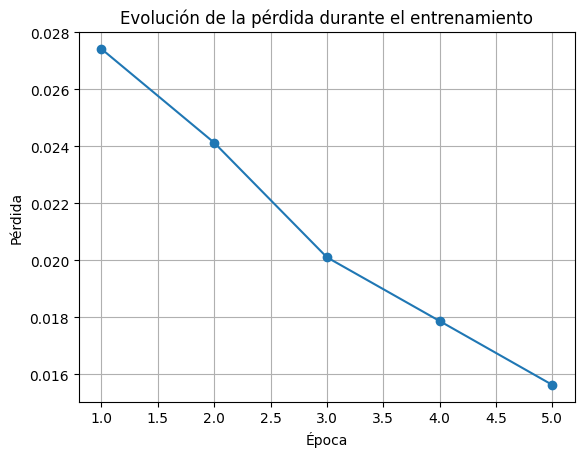

In [81]:
# Crear una gráfica de la pérdida
plt.plot(range(1, len(loss_list) + 1), loss_list, marker='o')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.grid(True)
plt.show()


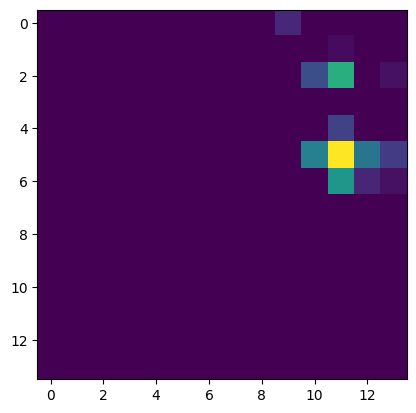

In [85]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models

# Cargar una imagen y aplicar transformaciones similares a las que usaste para entrenar el modelo
image_path = 'imagenes/13.jpg'
image = Image.open(image_path).convert('RGB')

# Aplicar las transformaciones de preprocesamiento
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Preprocesar la imagen
input_image = preprocess(image).unsqueeze(0)

# Mover la imagen a la GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_image = input_image.to(device)

# Cargar el modelo VGG preentrenado
vgg_model = models.vgg16(pretrained=True)

# Extraer solo las capas convolucionales (features)
feature_extractor = nn.Sequential(*list(vgg_model.features.children())[:30])

# Mover el modelo a la GPU si está disponible
feature_extractor = feature_extractor.to(device)

# Establecer el modelo en modo de evaluación (no afecta a la funcionalidad, pero es una buena práctica)
feature_extractor.eval()

# Pasar la imagen por las capas convolucionales (features)
with torch.no_grad():
    output_features = feature_extractor(input_image)

# Obtener el "feature map" de la última capa con 512 canales
last_layer_feature_map = output_features.squeeze()[511]  # Escoger el canal 512

# Mostrar el "feature map" de la última capa con 512 canales
plt.imshow(last_layer_feature_map.cpu(), cmap='viridis')  # Mover a CPU para mostrar la imagen
plt.show()


In [73]:
# import pydicom
# import cv2
# from PIL import Image
# import numpy as np

# # Leer el archivo DICOM
# dicom_file_path = 'train_images/1.2.826.0.1.3680043.14/1.dcm'
# dicom_data = pydicom.dcmread(dicom_file_path)
# gray_image = dicom_data.pixel_array

# # Normalizar la imagen en escala de grises
# normalized_gray_image = gray_image / np.max(gray_image)

# # Crear una imagen RGB a partir de la imagen en escala de grises
# # Asignar el valor de intensidad de grises a los canales R, G y B
# rgb_image = cv2.cvtColor((normalized_gray_image * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

# # print(rgb_image.shape)
# # # Guardar la imagen RGB en formato PNG o cualquier otro formato de imagen
# cv2.imwrite('output_rgb_image.png', rgb_image)


In [59]:
# import pydicom
# import matplotlib.pyplot as plt

# # Ruta de tu archivo DICOM
# dicom_file_path = 'train_images/1.2.826.0.1.3680043.14/1.dcm'

# # Cargar la imagen DICOM
# dicom_data = pydicom.dcmread(dicom_file_path)

# # Obtener la matriz de píxeles (imagen en escala de grises)
# image_array = dicom_data.pixel_array

# # Mostrar la imagen en escala de grises
# plt.imshow(image_array, cmap='gray')
# plt.title('Imagen DICOM en escala de grises')
# plt.colorbar()  # Añadir una barra de colores
# plt.show()
